# Khám Phá Dữ Liệu MALLORN - Phân Tích Chi Tiết

Dựa trên paper: "MALLORN: Many Artificial LSST Lightcurves based on Observations of Real Nuclear transients"

## Những hiểu biết then chốt từ paper:
1. **Baseline**: Tính trung bình có trọng số inverse-variance của flux trong 100 ngày TRƯỚC khi bùng sáng
2. **Detection threshold**: Ngưỡng 5σ (SNR > 5)
3. **some_color metric**: Yêu cầu phát hiện pre-peak + near-peak (3 bands) + post-peak  
4. **Đặc điểm TDE**: Màu xanh (blue), kéo dài ~400 ngày, evolution smooth, nhiệt độ ~13000K

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = Path('mallorn-astronomical-classification-challenge')
BANDS = ['u', 'g', 'r', 'i', 'z', 'y']
sns.set_style('whitegrid')

print("Data directory:", DATA_DIR)

Data directory: mallorn-astronomical-classification-challenge


## 1. Tải Metadata (Siêu dữ liệu)

Đọc file train_log.csv và test_log.csv để hiểu cấu trúc cơ bản của dữ liệu.

In [2]:
train_log = pd.read_csv(DATA_DIR / 'train_log.csv')
test_log = pd.read_csv(DATA_DIR / 'test_log.csv')

print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Training samples: {len(train_log)}")
print(f"Testing samples: {len(test_log)}")
print(f"Total: {len(train_log) + len(test_log)}")
print(f"\nTrain/Test split: {len(train_log)/(len(train_log)+len(test_log))*100:.1f}% / {len(test_log)/(len(train_log)+len(test_log))*100:.1f}%")

DATASET OVERVIEW
Training samples: 3043
Testing samples: 7135
Total: 10178

Train/Test split: 29.9% / 70.1%


### Quan sát về cột dữ liệu

**Train set** có thêm 2 cột quan trọng:
- `SpecType`: Loại thiên thể theo phân loại quang phổ (AGN, SN Ia, TDE, v.v.)
- `target`: Nhãn phân loại nhị phân (0 = Non-TDE, 1 = TDE)

**Test set** không có 2 cột này - đây chính là điều chúng ta cần dự đoán!

In [4]:
print("\n" + "="*60)
print("TEST SET COLUMNS")
print("="*60)
print(test_log.columns.tolist())
print("\nFirst 5 rows:")
test_log.head()


TEST SET COLUMNS
['object_id', 'Z', 'Z_err', 'EBV', 'SpecType', 'English Translation', 'split']

First 5 rows:


,object_id,Z,Z_err,EBV,SpecType,English Translation,split
0,Eluwaith_Mithrim_nothrim,0.5393,0.03013,0.610,NaN,Sindar + Sindar + family,split_01
1,Eru_heledir_archam,0.7282,0.03508,0.058,NaN,God + kingfisher (bird) + throne,split_01
2,Gonhir_anann_fuin,0.6026,0.03185,0.070,NaN,"Master of Stone, Dwarf + long, for a long tim...",split_01
3,Gwathuirim_haradrim_tegilbor,0.5298,0.03013,0.014,NaN,Shadowy People (of Dunland) + People of the S...,split_01
4,achas_minai_maen,0.1654,0.02304,0.027,NaN,"achas + distinct, unique, single + clever, sk...",split_01


## 2. Phân Bố Lớp (Class Distribution)

**Quan sát quan trọng:** TDE là sự kiện hiếm (~6% trong tập huấn luyện) - đây là bài toán **class imbalance nghiêm trọng**!

In [5]:
print("\n" + "="*60)
print("CLASS DISTRIBUTION (Training Set)")
print("="*60)

spec_counts = train_log['SpecType'].value_counts()
print("\nSpecType counts:")
print(spec_counts)

print(f"\n\nTarget distribution:")
print(f"  TDE (target=1): {train_log['target'].sum()} ({100*train_log['target'].mean():.2f}%)")
print(f"  Non-TDE (target=0): {(train_log['target']==0).sum()} ({100*(1-train_log['target'].mean()):.2f}%)")


CLASS DISTRIBUTION (Training Set)

SpecType counts:
SpecType
AGN                  1786
SN Ia                 790
SN II                 163
TDE                   148
SN IIn                 41
SN Ic                  21
SN Ia-91T-like         17
SLSN-I                 15
SN Ic-BL               12
SLSN-II                10
SN Ib                   9
SN Ia-pec               8
SN IIb                  8
SN IIP                  6
SN Iax[02cx-like]       5
SN Ia-91bg-like         4
Name: count, dtype: int64


Target distribution:
  TDE (target=1): 148 (4.86%)
  Non-TDE (target=0): 2895 (95.14%)


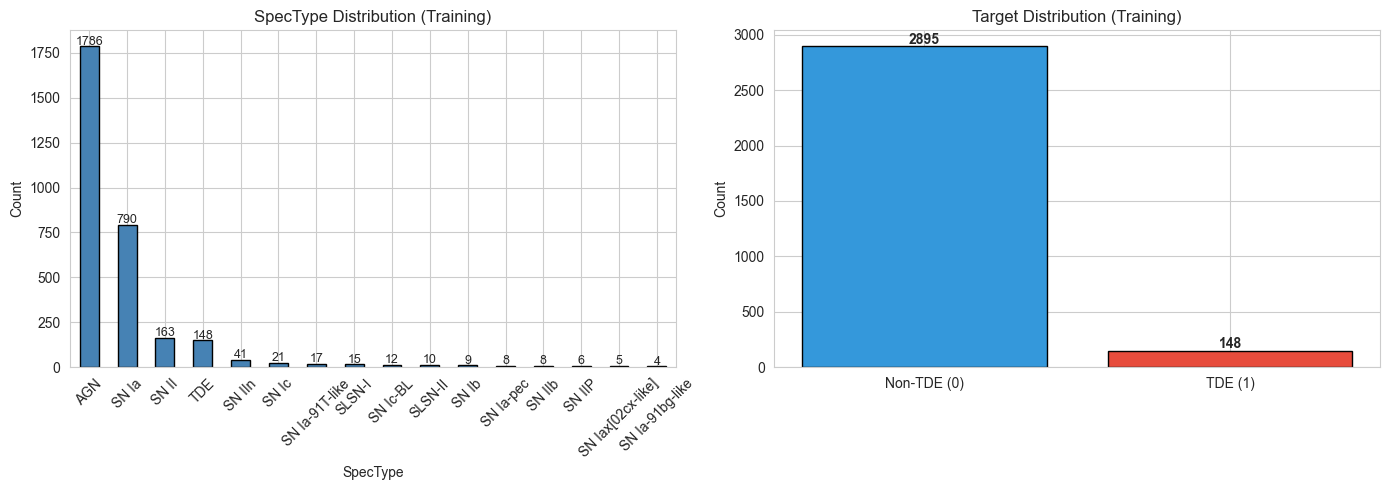


Class imbalance ratio: 19.6:1


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SpecType distribution
ax1 = axes[0]
spec_counts.plot(kind='bar', ax=ax1, color='steelblue', edgecolor='black')
ax1.set_title('SpecType Distribution (Training)')
ax1.set_xlabel('SpecType')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)
for i, v in enumerate(spec_counts.values):
    ax1.text(i, v + 10, str(v), ha='center', fontsize=9)

# Target distribution
ax2 = axes[1]
target_counts = train_log['target'].value_counts().sort_index()
bars = ax2.bar(['Non-TDE (0)', 'TDE (1)'], target_counts.values, color=['#3498db', '#e74c3c'], edgecolor='black')
ax2.set_title('Target Distribution (Training)')
ax2.set_ylabel('Count')
for bar, count in zip(bars, target_counts.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, f'{count}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150)
plt.show()

print(f"\nClass imbalance ratio: {(train_log['target']==0).sum() / train_log['target'].sum():.1f}:1")

## 3. Phân Bố Redshift (Độ Dịch Chuyển Đỏ)

Paper lưu ý: Hầu hết TDE của LSST sẽ ở redshift cao (z > 0.1), khiến việc phát hiện khó khăn hơn.

In [7]:
print("\n" + "="*60)
print("REDSHIFT DISTRIBUTION")
print("="*60)

print("\nTraining set (spectroscopic redshift):")
print(train_log['Z'].describe())

print("\nTest set (photometric redshift):")
print(test_log['Z'].describe())

print("\nTest set redshift error:")
print(test_log['Z_err'].describe())


REDSHIFT DISTRIBUTION

Training set (spectroscopic redshift):
count    3043.000000
mean        0.670674
std         0.539269
min         0.008771
25%         0.317750
50%         0.481800
75%         0.883550
max         4.924000
Name: Z, dtype: float64

Test set (photometric redshift):
count    7135.000000
mean        0.671834
std         0.552350
min        -0.017510
25%         0.317050
50%         0.484200
75%         0.869900
max         4.935000
Name: Z, dtype: float64

Test set redshift error:
count    7135.000000
mean        0.033450
std         0.011035
min         0.020190
25%         0.026400
50%         0.029650
75%         0.037465
max         0.116970
Name: Z_err, dtype: float64


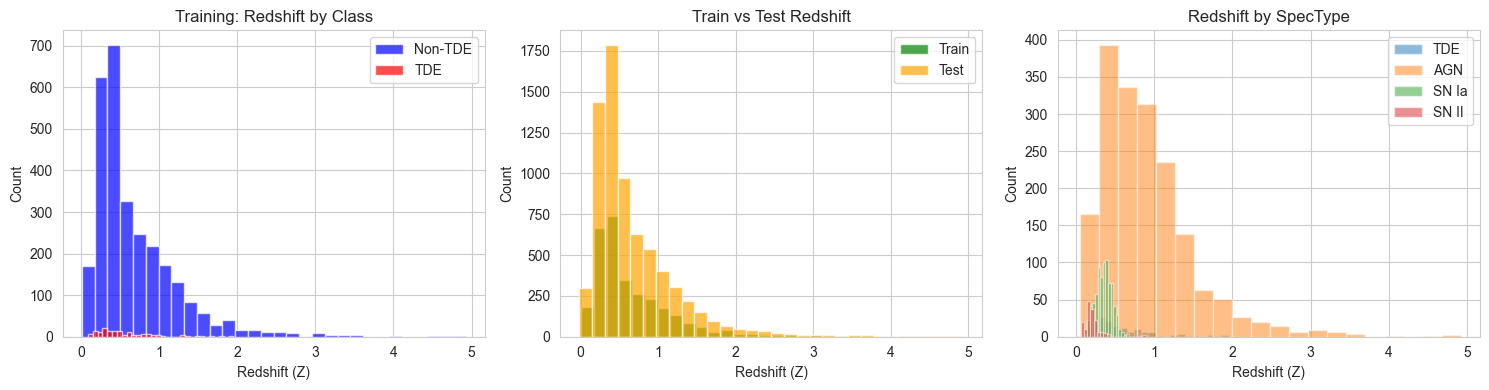

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Train redshift by class
ax1 = axes[0]
train_log[train_log['target']==0]['Z'].hist(bins=30, alpha=0.7, label='Non-TDE', ax=ax1, color='blue')
train_log[train_log['target']==1]['Z'].hist(bins=30, alpha=0.7, label='TDE', ax=ax1, color='red')
ax1.set_xlabel('Redshift (Z)')
ax1.set_ylabel('Count')
ax1.set_title('Training: Redshift by Class')
ax1.legend()

# Train vs Test redshift
ax2 = axes[1]
train_log['Z'].hist(bins=30, alpha=0.7, label='Train', ax=ax2, color='green')
test_log['Z'].hist(bins=30, alpha=0.7, label='Test', ax=ax2, color='orange')
ax2.set_xlabel('Redshift (Z)')
ax2.set_ylabel('Count')
ax2.set_title('Train vs Test Redshift')
ax2.legend()

# Redshift by SpecType
ax3 = axes[2]
for spec_type in ['TDE', 'AGN', 'SN Ia', 'SN II']:
    if spec_type in train_log['SpecType'].values:
        train_log[train_log['SpecType']==spec_type]['Z'].hist(bins=20, alpha=0.5, label=spec_type, ax=ax3)
ax3.set_xlabel('Redshift (Z)')
ax3.set_ylabel('Count')
ax3.set_title('Redshift by SpecType')
ax3.legend()

plt.tight_layout()
plt.savefig('redshift_distribution.png', dpi=150)
plt.show()

In [9]:
print("\nRedshift stats by SpecType:")
print(train_log.groupby('SpecType')['Z'].agg(['count', 'mean', 'std', 'min', 'max']).round(3))


Redshift stats by SpecType:
                   count   mean    std    min    max
SpecType                                            
AGN                 1786  0.886  0.596  0.042  4.924
SLSN-I                15  0.754  0.180  0.496  1.064
SLSN-II               10  0.582  0.119  0.464  0.887
SN II                163  0.206  0.118  0.057  0.889
SN IIP                 6  0.438  0.203  0.237  0.665
SN IIb                 8  0.174  0.106  0.061  0.295
SN IIn                41  0.464  0.162  0.206  0.740
SN Ia                790  0.355  0.102  0.009  0.672
SN Ia-91T-like        17  0.471  0.052  0.389  0.560
SN Ia-91bg-like        4  0.180  0.126  0.111  0.369
SN Ia-pec              8  0.278  0.042  0.213  0.336
SN Iax[02cx-like]      5  0.248  0.014  0.234  0.270
SN Ib                  9  0.151  0.034  0.099  0.187
SN Ic                 21  0.207  0.096  0.098  0.404
SN Ic-BL              12  0.288  0.068  0.207  0.408
TDE                  148  0.556  0.384  0.087  1.951


## 4. Phân Bố Extinction E(B-V)

E(B-V) đo lường mức độ bụi giữa các vì sao làm suy giảm ánh sáng. Giá trị càng cao, ánh sáng càng bị hấp thụ nhiều bởi bụi.


EXTINCTION E(B-V) DISTRIBUTION

Training set:
count    3043.000000
mean        0.055547
std         0.061349
min         0.002000
25%         0.020000
50%         0.037000
75%         0.069000
max         0.758000
Name: EBV, dtype: float64


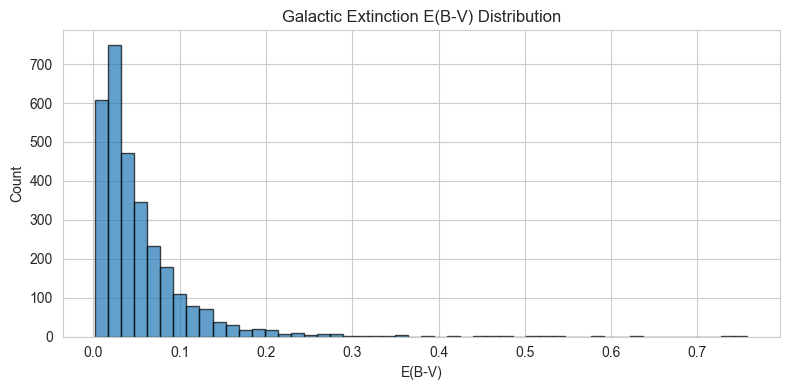

In [10]:
print("\n" + "="*60)
print("EXTINCTION E(B-V) DISTRIBUTION")
print("="*60)

print("\nTraining set:")
print(train_log['EBV'].describe())

fig, ax = plt.subplots(figsize=(8, 4))
train_log['EBV'].hist(bins=50, ax=ax, edgecolor='black', alpha=0.7)
ax.set_xlabel('E(B-V)')
ax.set_ylabel('Count')
ax.set_title('Galactic Extinction E(B-V) Distribution')
plt.tight_layout()
plt.show()

## 5. Phân Tích Lightcurve (Đường Cong Ánh Sáng)

Lightcurve là chuỗi thời gian ghi lại độ sáng của thiên thể theo thời gian và qua các filter (băng sóng) khác nhau.

In [11]:
# Load sample lightcurve data
lc_file = DATA_DIR / 'split_01' / 'train_full_lightcurves.csv'
lc_df = pd.read_csv(lc_file)

print("\n" + "="*60)
print("LIGHTCURVE DATA STRUCTURE")
print("="*60)
print(f"\nColumns: {lc_df.columns.tolist()}")
print(f"\nSample data:")
lc_df.head(10)


LIGHTCURVE DATA STRUCTURE

Columns: ['object_id', 'Time (MJD)', 'Flux', 'Flux_err', 'Filter']

Sample data:


,object_id,Time (MJD),Flux,Flux_err,Filter
0,Dornhoth_fervain_onodrim,63314.4662,-1.630159,0.365777,z
1,Dornhoth_fervain_onodrim,63780.9674,10.499389,0.253867,r
2,Dornhoth_fervain_onodrim,63789.7693,5.866250,1.559241,y
3,Dornhoth_fervain_onodrim,63794.1702,3.903623,0.376854,r
4,Dornhoth_fervain_onodrim,63794.1702,5.226644,0.516864,i
5,Dornhoth_fervain_onodrim,63824.9769,0.984804,0.109919,g
6,Dornhoth_fervain_onodrim,63824.9769,1.485012,0.181529,r
7,Dornhoth_fervain_onodrim,63829.3779,0.170766,0.551879,u
8,Dornhoth_fervain_onodrim,63829.3779,1.183222,0.208419,r
9,Dornhoth_fervain_onodrim,63842.5807,0.725684,0.533212,i


In [12]:
print("\n" + "="*60)
print("FLUX STATISTICS")
print("="*60)

print("\nFlux overall:")
print(lc_df['Flux'].describe())

print(f"\nNegative flux count: {(lc_df['Flux'] < 0).sum()} ({100*(lc_df['Flux'] < 0).mean():.1f}%)")
print(f"Zero flux count: {(lc_df['Flux'] == 0).sum()}")

print("\nFlux error:")
print(lc_df['Flux_err'].describe())


FLUX STATISTICS

Flux overall:
count    26313.000000
mean         0.501459
std          1.953118
min         -9.462068
25%         -0.187571
50%          0.132438
75%          0.785759
max         44.168901
Name: Flux, dtype: float64

Negative flux count: 10254 (39.0%)
Zero flux count: 0

Flux error:
count    26324.000000
mean         0.454371
std          0.445943
min          0.029821
25%          0.181898
50%          0.305917
75%          0.525337
max          7.688937
Name: Flux_err, dtype: float64


In [13]:
print("\nFlux by band:")
for band in BANDS:
    band_data = lc_df[lc_df['Filter'] == band]
    if len(band_data) > 0:
        neg_frac = (band_data['Flux'] < 0).mean()
        snr = band_data['Flux'] / band_data['Flux_err']
        det_frac = (snr > 5).mean()
        print(f"  {band}: n={len(band_data)}, flux_mean={band_data['Flux'].mean():.2f}, "
              f"neg_frac={neg_frac:.2f}, det_frac(SNR>5)={det_frac:.2f}")


Flux by band:
  u: n=2405, flux_mean=0.22, neg_frac=0.42, det_frac(SNR>5)=0.05
  g: n=2845, flux_mean=0.35, neg_frac=0.39, det_frac(SNR>5)=0.19
  r: n=5985, flux_mean=0.55, neg_frac=0.37, det_frac(SNR>5)=0.22
  i: n=5877, flux_mean=0.58, neg_frac=0.39, det_frac(SNR>5)=0.17
  z: n=5324, flux_mean=0.59, neg_frac=0.38, det_frac(SNR>5)=0.10
  y: n=3888, flux_mean=0.48, neg_frac=0.42, det_frac(SNR>5)=0.02


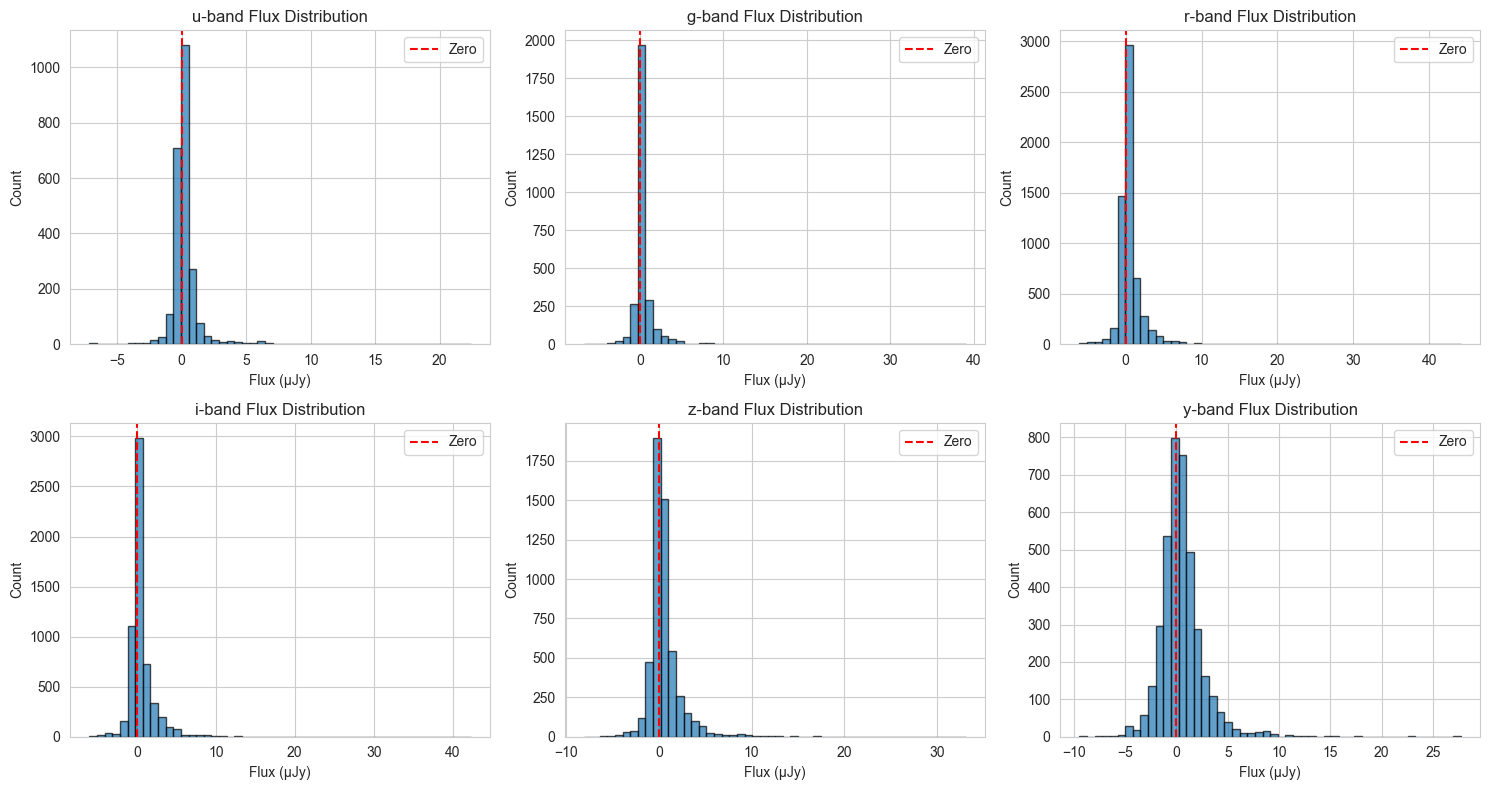

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, band in enumerate(BANDS):
    band_data = lc_df[lc_df['Filter'] == band]
    ax = axes[i]
    
    # Clip for visualization
    flux_clip = band_data['Flux'].clip(-20, 50)
    ax.hist(flux_clip, bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(0, color='red', linestyle='--', label='Zero')
    ax.set_xlabel('Flux (μJy)')
    ax.set_ylabel('Count')
    ax.set_title(f'{band}-band Flux Distribution')
    ax.legend()

plt.tight_layout()
plt.savefig('flux_by_band.png', dpi=150)
plt.show()

## 6. Ví Dụ Lightcurves: So Sánh TDE vs Non-TDE

**Mục tiêu**: Quan sát sự khác biệt về hình dạng lightcurve giữa TDE và các loại thiên thể khác (AGN, SN).

In [15]:
# Get TDE and non-TDE examples from split_01
split1_train = train_log[train_log['split'] == 'split_01']
tde_ids = split1_train[split1_train['target'] == 1]['object_id'].tolist()
non_tde_ids = split1_train[split1_train['target'] == 0]['object_id'].tolist()

print(f"TDEs in split_01: {len(tde_ids)}")
print(f"Non-TDEs in split_01: {len(non_tde_ids)}")

if tde_ids:
    print(f"\nTDE examples: {tde_ids[:3]}")
print(f"Non-TDE examples: {non_tde_ids[:3]}")

TDEs in split_01: 12
Non-TDEs in split_01: 143

TDE examples: ['amon_imloth_luin', 'drafn_araf_ryn', 'elu_rusc_nath']
Non-TDE examples: ['Dornhoth_fervain_onodrim', 'Dornhoth_galadh_ylf', 'Elrim_melethril_thul']


In [16]:
def plot_lightcurve(obj_id, lc_df, title_suffix=''):
    """Plot 6-band lightcurve for an object."""
    obj_data = lc_df[lc_df['object_id'] == obj_id]
    
    if len(obj_data) == 0:
        print(f"No data for {obj_id}")
        return
    
    fig, ax = plt.subplots(figsize=(12, 5))
    
    colors = {'u': 'purple', 'g': 'green', 'r': 'red', 'i': 'orange', 'z': 'brown', 'y': 'black'}
    
    for band in BANDS:
        band_data = obj_data[obj_data['Filter'] == band].sort_values('Time (MJD)')
        if len(band_data) > 0:
            ax.errorbar(band_data['Time (MJD)'], band_data['Flux'], 
                       yerr=band_data['Flux_err'], fmt='o', label=band,
                       color=colors[band], markersize=4, alpha=0.7, capsize=2)
    
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Time (MJD)')
    ax.set_ylabel('Flux (μJy)')
    ax.set_title(f'{obj_id} {title_suffix}')
    ax.legend(ncol=6, loc='upper right')
    plt.tight_layout()
    return fig


TDE LIGHTCURVE EXAMPLES


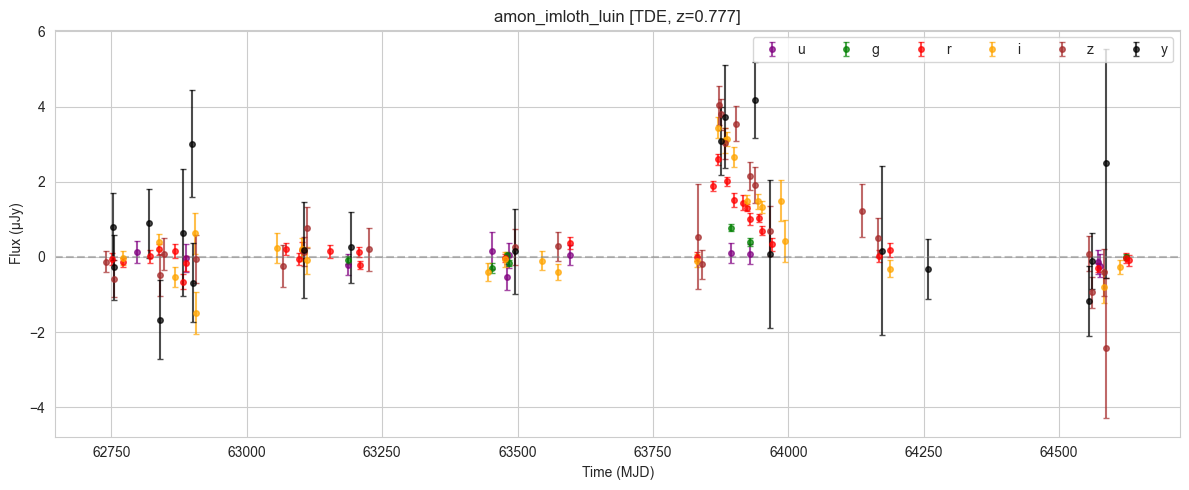

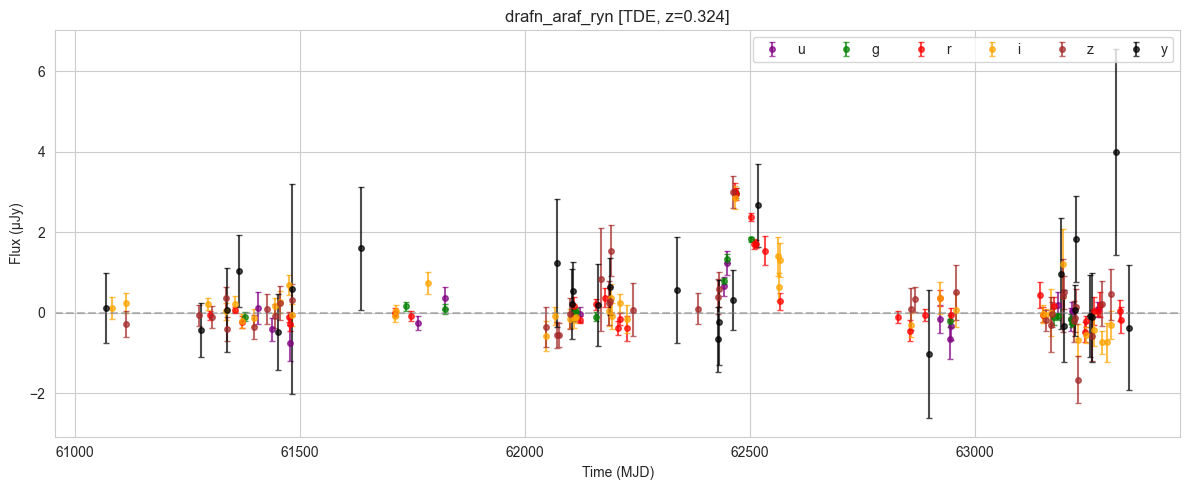

In [17]:
# Plot TDE examples
print("\n" + "="*60)
print("TDE LIGHTCURVE EXAMPLES")
print("="*60)

for obj_id in tde_ids[:2]:
    spec_type = train_log[train_log['object_id']==obj_id]['SpecType'].values[0]
    z = train_log[train_log['object_id']==obj_id]['Z'].values[0]
    plot_lightcurve(obj_id, lc_df, f'[TDE, z={z:.3f}]')
    plt.show()


NON-TDE LIGHTCURVE EXAMPLES


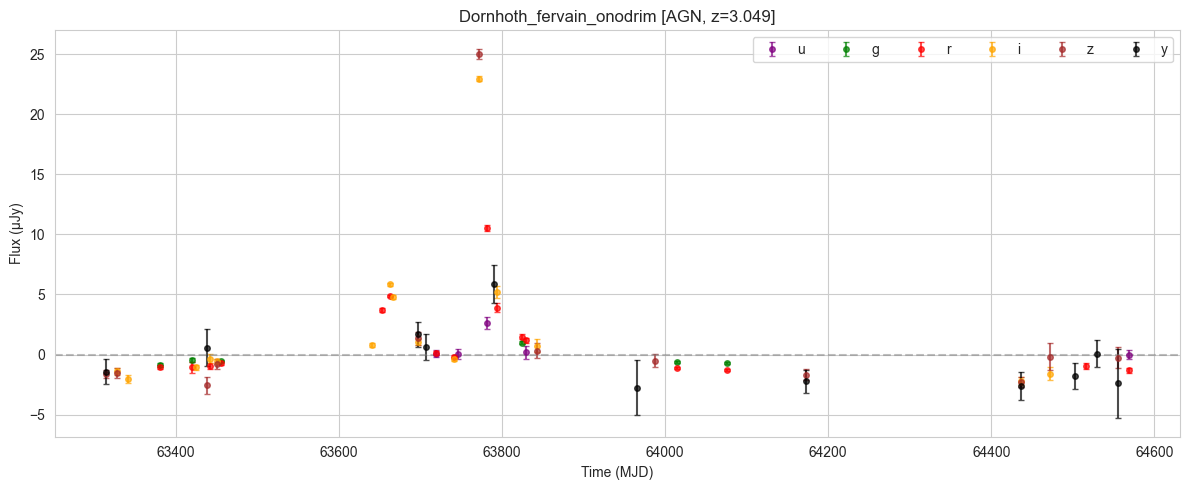

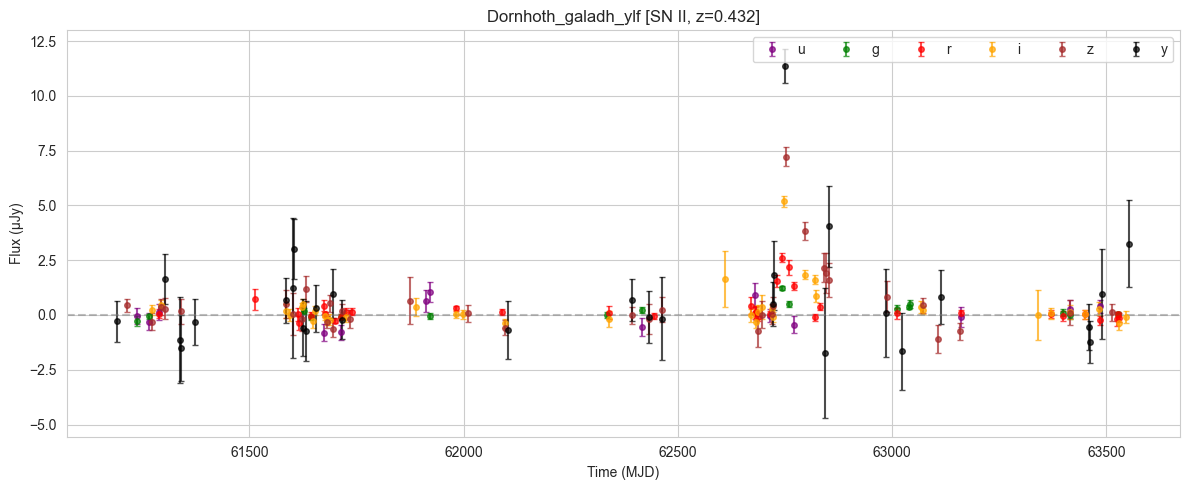

In [18]:
# Plot non-TDE examples (AGN and SN)
print("\n" + "="*60)
print("NON-TDE LIGHTCURVE EXAMPLES")
print("="*60)

# Get one AGN and one SN
agn_ids = split1_train[(split1_train['target']==0) & (split1_train['SpecType']=='AGN')]['object_id'].tolist()
sn_ids = split1_train[(split1_train['target']==0) & (split1_train['SpecType'].str.startswith('SN'))]['object_id'].tolist()

if agn_ids:
    obj_id = agn_ids[0]
    z = train_log[train_log['object_id']==obj_id]['Z'].values[0]
    plot_lightcurve(obj_id, lc_df, f'[AGN, z={z:.3f}]')
    plt.show()

if sn_ids:
    obj_id = sn_ids[0]
    spec = train_log[train_log['object_id']==obj_id]['SpecType'].values[0]
    z = train_log[train_log['object_id']==obj_id]['Z'].values[0]
    plot_lightcurve(obj_id, lc_df, f'[{spec}, z={z:.3f}]')
    plt.show()

## 7. Phân Tích Metrics từ Paper: some_color và some_color_pu

Đây là 2 metrics quan trọng được định nghĩa trong paper MALLORN để đánh giá chất lượng quan sát:

**some_color** yêu cầu:
- ≥1 detection ở giai đoạn pre-peak (trước đỉnh sáng, t < t_peak - 10 ngày)
- ≥3 detections ở ≥3 bands trong vòng 10 ngày quanh đỉnh sáng
- ≥2 detections ở ≥2 bands trong khoảng 10-30 ngày sau đỉnh sáng

**some_color_pu** (pu = purple, ưu tiên u-band) yêu cầu:
- ≥1 detection ở giai đoạn pre-peak
- ≥1 u-band detection + ≥1 band khác trong vòng 10 ngày quanh đỉnh
- ≥1 detection ở band khác trong khoảng 10-30 ngày sau đỉnh

In [19]:
def compute_some_color_metrics(obj_id, lc_df, snr_thresh=5):
    """Compute some_color and some_color_pu metrics from the paper.
    
    some_color requires:
    - ≥1 detection pre-peak (t < t_peak - 10 days)
    - ≥3 detections in ≥3 bands within 10 days of peak
    - ≥2 detections in ≥2 bands 10-30 days after peak
    
    some_color_pu requires:
    - ≥1 detection pre-peak
    - ≥1 u-band detection + ≥1 other band within 10 days of peak
    - ≥1 detection in another band 10-30 days after peak
    """
    obj_data = lc_df[lc_df['object_id'] == obj_id].copy()
    if len(obj_data) == 0:
        return {'some_color': False, 'some_color_pu': False}
    
    # Calculate SNR and find detections
    obj_data['SNR'] = obj_data['Flux'] / obj_data['Flux_err']
    detections = obj_data[obj_data['SNR'] > snr_thresh]
    
    if len(detections) == 0:
        return {'some_color': False, 'some_color_pu': False}
    
    # Find peak time (max flux among detections)
    peak_idx = detections['Flux'].idxmax()
    peak_time = detections.loc[peak_idx, 'Time (MJD)']
    
    # Classify detections by phase
    detections = detections.copy()
    detections['rel_time'] = detections['Time (MJD)'] - peak_time
    
    pre_peak = detections[detections['rel_time'] < -10]
    near_peak = detections[(detections['rel_time'] >= -10) & (detections['rel_time'] <= 10)]
    post_peak = detections[(detections['rel_time'] > 10) & (detections['rel_time'] <= 30)]
    
    # some_color metric
    has_pre = len(pre_peak) >= 1
    near_bands = near_peak['Filter'].nunique()
    near_count = len(near_peak)
    has_near = near_count >= 3 and near_bands >= 3
    post_bands = post_peak['Filter'].nunique()
    post_count = len(post_peak)
    has_post = post_count >= 2 and post_bands >= 2
    
    some_color = has_pre and has_near and has_post
    
    # some_color_pu metric
    has_u_near = 'u' in near_peak['Filter'].values
    has_other_near = near_peak[near_peak['Filter'] != 'u']['Filter'].nunique() >= 1
    has_other_post = len(post_peak) >= 1
    
    some_color_pu = has_pre and has_u_near and has_other_near and has_other_post
    
    return {
        'some_color': some_color,
        'some_color_pu': some_color_pu,
        'n_pre': len(pre_peak),
        'n_near': near_count,
        'n_near_bands': near_bands,
        'n_post': post_count,
        'n_post_bands': post_bands,
        'has_u_near': has_u_near
    }

In [20]:
# Compute metrics for split_01 objects
print("\n" + "="*60)
print("PAPER METRICS: some_color and some_color_pu")
print("="*60)

metrics_results = []
for obj_id in split1_train['object_id'].tolist():
    metrics = compute_some_color_metrics(obj_id, lc_df)
    metrics['object_id'] = obj_id
    metrics['target'] = train_log[train_log['object_id']==obj_id]['target'].values[0]
    metrics['SpecType'] = train_log[train_log['object_id']==obj_id]['SpecType'].values[0]
    metrics_results.append(metrics)

metrics_df = pd.DataFrame(metrics_results)

print(f"\nTotal objects in split_01: {len(metrics_df)}")
print(f"some_color passed: {metrics_df['some_color'].sum()} ({100*metrics_df['some_color'].mean():.1f}%)")
print(f"some_color_pu passed: {metrics_df['some_color_pu'].sum()} ({100*metrics_df['some_color_pu'].mean():.1f}%)")


PAPER METRICS: some_color and some_color_pu

Total objects in split_01: 155
some_color passed: 42 (27.1%)
some_color_pu passed: 12 (7.7%)


In [21]:
# Breakdown by class
print("\nMetrics by target class:")
print(metrics_df.groupby('target')[['some_color', 'some_color_pu']].mean().round(3))

print("\nMetrics by SpecType:")
print(metrics_df.groupby('SpecType')[['some_color', 'some_color_pu', 'has_u_near']].mean().round(3))


Metrics by target class:
        some_color  some_color_pu
target                           
0            0.280          0.084
1            0.167          0.000

Metrics by SpecType:
           some_color  some_color_pu  has_u_near
SpecType                                        
AGN             0.175          0.138       0.188
SN II           0.478          0.000       0.043
SN Ia           0.378          0.027       0.081
SN Ia-pec       0.500          0.000       0.000
SN Ib           0.000          0.000       0.000
TDE             0.167          0.000       0.167


## 8. Các Đặc Trưng Phân Biệt Chính (Key Differentiating Features)

Phân tích các features quan trọng giúp phân biệt TDE với các loại thiên thể khác.

In [22]:
def analyze_object(obj_id, lc_df):
    """Analyze key features for an object."""
    obj_data = lc_df[lc_df['object_id'] == obj_id].copy()
    if len(obj_data) == 0:
        return None
    
    obj_data['SNR'] = obj_data['Flux'] / obj_data['Flux_err']
    
    features = {'object_id': obj_id}
    
    # Overall stats
    features['n_obs'] = len(obj_data)
    features['n_det'] = (obj_data['SNR'] > 5).sum()
    features['n_bands'] = obj_data['Filter'].nunique()
    
    # Time span
    features['time_span'] = obj_data['Time (MJD)'].max() - obj_data['Time (MJD)'].min()
    
    # By band
    band_fluxes = {}
    for band in BANDS:
        band_data = obj_data[obj_data['Filter'] == band]
        if len(band_data) > 0:
            features[f'{band}_n'] = len(band_data)
            features[f'{band}_max'] = band_data['Flux'].max()
            features[f'{band}_det'] = (band_data['SNR'] > 5).sum()
            
            # Mean of detections
            det_data = band_data[band_data['SNR'] > 5]
            if len(det_data) > 0:
                band_fluxes[band] = det_data['Flux'].mean()
        else:
            features[f'{band}_n'] = 0
            features[f'{band}_max'] = 0
            features[f'{band}_det'] = 0
    
    # Color: u-g (blue = negative)
    if 'u' in band_fluxes and 'g' in band_fluxes and band_fluxes['u'] > 0 and band_fluxes['g'] > 0:
        features['color_u_g'] = -2.5 * np.log10(band_fluxes['u'] / band_fluxes['g'])
    else:
        features['color_u_g'] = np.nan
    
    # Blue fraction
    blue = band_fluxes.get('u', 0) + band_fluxes.get('g', 0)
    total = sum(band_fluxes.values())
    features['blue_fraction'] = blue / (total + 1e-10) if total > 0 else 0
    
    return features

In [23]:
# Analyze all split_01 objects
analysis_results = []
for obj_id in split1_train['object_id'].tolist():
    feats = analyze_object(obj_id, lc_df)
    if feats:
        feats['target'] = train_log[train_log['object_id']==obj_id]['target'].values[0]
        feats['SpecType'] = train_log[train_log['object_id']==obj_id]['SpecType'].values[0]
        analysis_results.append(feats)

analysis_df = pd.DataFrame(analysis_results)
analysis_df.head()

,object_id,n_obs,n_det,n_bands,time_span,u_n,u_max,u_det,g_n,g_max,...,z_n,z_max,z_det,y_n,y_max,y_det,color_u_g,blue_fraction,target,SpecType
0,Dornhoth_fervain_onodrim,65,13,6,1254.2719,5,2.626294,1,6,0.984804,...,12,25.047343,1,11,5.866250,0,-1.064984,0.084717,0,AGN
1,Dornhoth_galadh_ylf,167,11,6,2362.1560,15,1.060514,0,16,1.250010,...,35,7.229639,2,29,11.375499,1,NaN,0.054434,0,SN II
2,Elrim_melethril_thul,35,20,6,1206.0218,5,0.367624,0,9,1.255934,...,8,6.617915,7,2,6.466151,1,NaN,0.054771,0,AGN
3,Ithil_tobas_rodwen,798,82,6,2858.4129,108,1.607904,0,134,1.369338,...,132,2.986381,4,115,5.353821,0,NaN,0.142299,0,AGN
4,Mirion_adar_Druadan,129,18,6,2202.3065,13,0.530415,0,14,1.480954,...,27,2.701716,1,14,2.370519,0,NaN,0.149300,0,AGN


In [24]:
print("\n" + "="*60)
print("KEY FEATURES BY CLASS")
print("="*60)

key_features = ['n_det', 'time_span', 'u_det', 'blue_fraction', 'color_u_g']
print("\nMean values by target:")
print(analysis_df.groupby('target')[key_features].mean().round(3))

print("\nMean values by SpecType:")
print(analysis_df.groupby('SpecType')[key_features].mean().round(3))


KEY FEATURES BY CLASS

Mean values by target:
         n_det  time_span  u_det  blue_fraction  color_u_g
target                                                    
0       23.615   2118.055  0.755          0.207     -0.109
1       13.583   1808.657  0.417          0.283     -0.382

Mean values by SpecType:
            n_det  time_span  u_det  blue_fraction  color_u_g
SpecType                                                     
AGN        29.750   2227.838  1.175          0.256     -0.224
SN II      17.870   1883.106  0.217          0.123     -0.250
SN Ia      14.946   2109.377  0.243          0.158      0.764
SN Ia-pec  11.500    840.402  0.000          0.176        NaN
SN Ib      10.000   1615.629  0.000          0.079        NaN
TDE        13.583   1808.657  0.417          0.283     -0.382


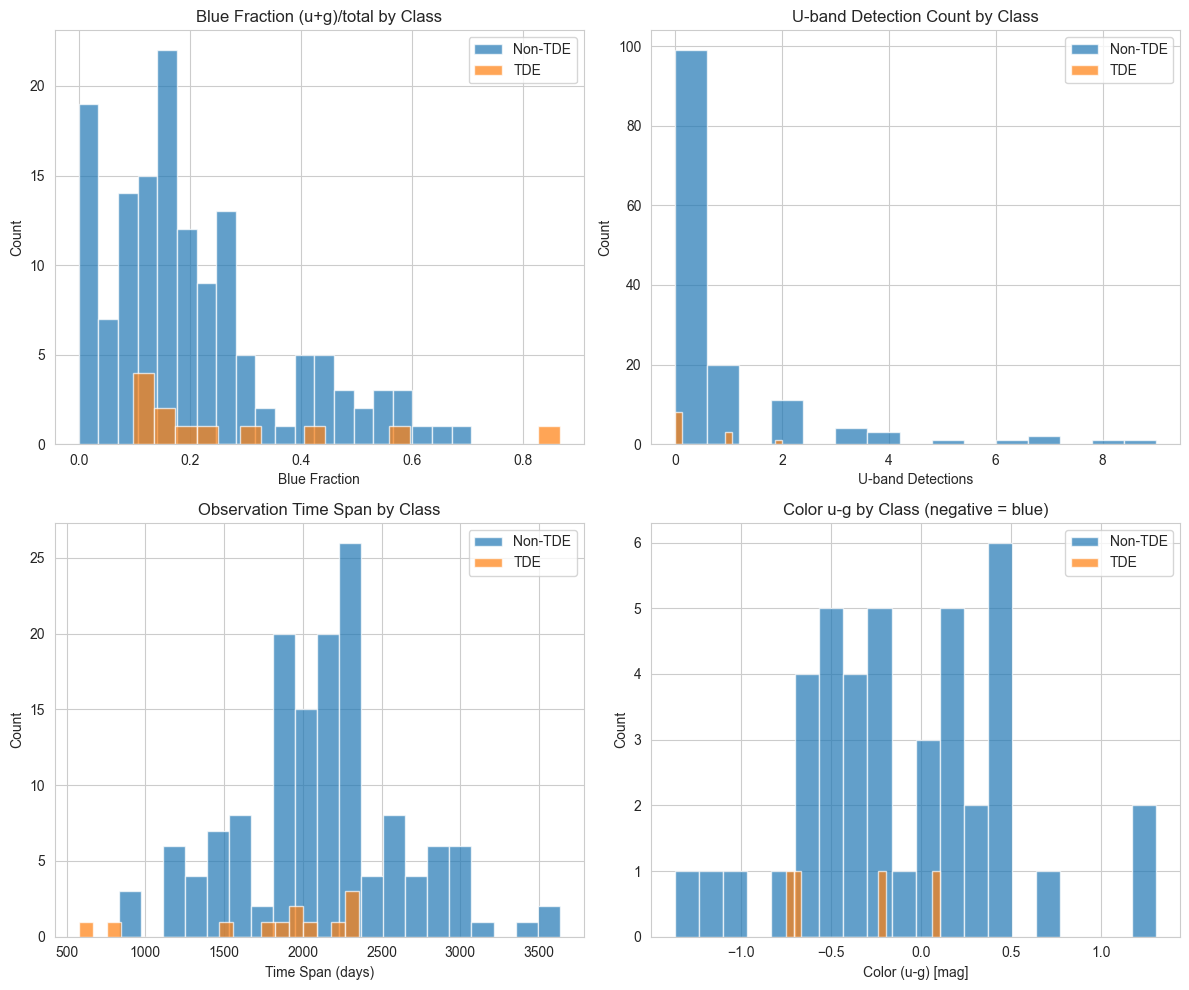

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Blue fraction by class
ax1 = axes[0, 0]
analysis_df[analysis_df['target']==0]['blue_fraction'].hist(bins=20, alpha=0.7, label='Non-TDE', ax=ax1)
analysis_df[analysis_df['target']==1]['blue_fraction'].hist(bins=20, alpha=0.7, label='TDE', ax=ax1)
ax1.set_xlabel('Blue Fraction')
ax1.set_ylabel('Count')
ax1.set_title('Blue Fraction (u+g)/total by Class')
ax1.legend()

# U-band detections by class
ax2 = axes[0, 1]
analysis_df[analysis_df['target']==0]['u_det'].hist(bins=15, alpha=0.7, label='Non-TDE', ax=ax2)
analysis_df[analysis_df['target']==1]['u_det'].hist(bins=15, alpha=0.7, label='TDE', ax=ax2)
ax2.set_xlabel('U-band Detections')
ax2.set_ylabel('Count')
ax2.set_title('U-band Detection Count by Class')
ax2.legend()

# Time span by class
ax3 = axes[1, 0]
analysis_df[analysis_df['target']==0]['time_span'].hist(bins=20, alpha=0.7, label='Non-TDE', ax=ax3)
analysis_df[analysis_df['target']==1]['time_span'].hist(bins=20, alpha=0.7, label='TDE', ax=ax3)
ax3.set_xlabel('Time Span (days)')
ax3.set_ylabel('Count')
ax3.set_title('Observation Time Span by Class')
ax3.legend()

# Color u-g by class
ax4 = axes[1, 1]
non_tde_color = analysis_df[(analysis_df['target']==0) & (analysis_df['color_u_g'].notna())]['color_u_g']
tde_color = analysis_df[(analysis_df['target']==1) & (analysis_df['color_u_g'].notna())]['color_u_g']
if len(non_tde_color) > 0:
    non_tde_color.hist(bins=20, alpha=0.7, label='Non-TDE', ax=ax4)
if len(tde_color) > 0:
    tde_color.hist(bins=20, alpha=0.7, label='TDE', ax=ax4)
ax4.set_xlabel('Color (u-g) [mag]')
ax4.set_ylabel('Count')
ax4.set_title('Color u-g by Class (negative = blue)')
ax4.legend()

plt.tight_layout()
plt.savefig('key_features_by_class.png', dpi=150)
plt.show()

## 9. Tổng Kết và Khuyến Nghị

Dựa trên phân tích chi tiết dữ liệu và paper, đưa ra các khuyến nghị cho quá trình xây dựng mô hình.

In [26]:
print("\n" + "="*60)
print("SUMMARY AND RECOMMENDATIONS")
print("="*60)

print("""
KEY FINDINGS:

1. CLASS IMBALANCE:
   - TDEs are rare (~6% of training data)
   - Majority are AGN

2. TDE CHARACTERISTICS (from paper):
   - Blue (strong u-band emission)
   - Long duration (~400 days)
   - Smooth evolution (not stochastic like AGN)
   - Temperature ~13,000 K

3. KEY DIFFERENTIATING FEATURES:
   - U-band detection count
   - Blue fraction (u+g)/total
   - Color u-g (TDEs should be bluer/more negative)
   - Time span of detections
   - some_color and some_color_pu metrics

4. DATA PROCESSING RECOMMENDATIONS:
   - Use 5σ SNR threshold for detections (per paper)
   - Baseline: inverse-variance weighted mean of flux 100 days BEFORE rise
   - Implement some_color metrics as features
   - Focus on u-band features (TDE signature)
   - Consider AGN stochasticity vs TDE smoothness

5. POTENTIAL ISSUES WITH PREVIOUS VERSIONS:
   - v1.5 used wrong baseline estimation (negative flux, not pre-rise)
   - Color calculations may have been affected by negative flux
   - some_color metrics not properly implemented
""")


SUMMARY AND RECOMMENDATIONS

KEY FINDINGS:

1. CLASS IMBALANCE:
   - TDEs are rare (~6% of training data)
   - Majority are AGN

2. TDE CHARACTERISTICS (from paper):
   - Blue (strong u-band emission)
   - Long duration (~400 days)
   - Smooth evolution (not stochastic like AGN)
   - Temperature ~13,000 K

3. KEY DIFFERENTIATING FEATURES:
   - U-band detection count
   - Blue fraction (u+g)/total
   - Color u-g (TDEs should be bluer/more negative)
   - Time span of detections
   - some_color and some_color_pu metrics

4. DATA PROCESSING RECOMMENDATIONS:
   - Use 5σ SNR threshold for detections (per paper)
   - Baseline: inverse-variance weighted mean of flux 100 days BEFORE rise
   - Implement some_color metrics as features
   - Focus on u-band features (TDE signature)
   - Consider AGN stochasticity vs TDE smoothness

5. POTENTIAL ISSUES WITH PREVIOUS VERSIONS:
   - v1.5 used wrong baseline estimation (negative flux, not pre-rise)
   - Color calculations may have been affected by neg